In [ ]:
pip install d2l

In [ ]:
pip install mxnet

In [ ]:
from d2l import mxnet as d2l
from mxnet import autograd, gluon, np, npx, init
from mxnet.gluon import nn
npx.set_np()

net = nn.Sequential()
net.add(nn.Conv2D(channels=6, kernel_size=5, padding=2, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=16, kernel_size=5, activation='sigmoid'),
        nn.AvgPool2D(pool_size=2, strides=2),
        # Dense will transform the input of the shape (batch size, channel,
        # height, width) into the input of the shape (batch size,
        # channel * height * width) automatically by default
        nn.Dense(120, activation='sigmoid'),
        nn.Dense(84, activation='sigmoid'),
        nn.Dense(10))

In [ ]:
X = np.random.uniform(size=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

conv6 output shape:	 (1, 6, 28, 28)
pool6 output shape:	 (1, 6, 14, 14)
conv7 output shape:	 (1, 16, 10, 10)
pool7 output shape:	 (1, 16, 5, 5)
dense9 output shape:	 (1, 120)
dense10 output shape:	 (1, 84)
dense11 output shape:	 (1, 10)


In [ ]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, ctx=None):
    if not ctx:  # Query the first device the first parameter is on
        ctx = list(net.collect_params().values())[0].list_ctx()[0]
    metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
    for X, y in data_iter:
        X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
        metric.add(d2l.accuracy(net(X), y), y.size)
    return metric[0]/metric[1]

In [ ]:
def train_ch6(net, train_iter, test_iter, num_epochs, lr, ctx=d2l.try_gpu()):
    net.initialize(force_reinit=True, ctx=ctx, init=init.Xavier()) # tao moi mot mo hinh, dam bao mo hinh ban dau la moi
    loss = gluon.loss.SoftmaxCrossEntropyLoss() #dinh nghia ham mat mat duoc su dung de toi uu
    trainer = gluon.Trainer(net.collect_params(),
                            'sgd', {'learning_rate': lr}) #su dung SGD cho qua trinh toi uu và learningrate cho mô hình
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc']) #vẽ đồ thị
    timer = d2l.Timer() #tính toán thời gian thực hiện
    for epoch in range(num_epochs): #chạy lần lượt từng epochs
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples //Mảng cộng dồn lưu giá trị của 3 tham số phục vụ cho việc vẽ sơ đồ
        for i, (X, y) in enumerate(train_iter): #duyet qua tat ca cac bass
            timer.start()
            # Here is the only difference compared to train_epoch_ch3
            X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx) #chuyen du lieu sang gpu
            with autograd.record(): # cho phéo theo dõi quá trình tính toán trọng số
                y_hat = net(X) # tính giá trị dự đoán thông qua batch hiện tai
                l = loss(y_hat, y) #tinh toan sai so thong qua hàm loss da duoc dinh nghia
            l.backward() #tính toán thông số phục vụ cho việc cập nhật
            trainer.step(X.shape[0]) #cập nhật lại trọng số theo l.backwarkd đã thực hiện
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0]) #cập nhật mảng tích lũy
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2] #tính toán thông số để vẽ đồ thị
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter), (train_loss, train_acc, None)) #ve batch hien tai len do thi
        test_acc = evaluate_accuracy_gpu(net, test_iter) #tinh toan test_acc
        animator.add(epoch+1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (
        train_loss, train_acc, test_acc))
    print('%.1f examples/sec on %s' % (metric[2]*num_epochs/timer.sum(), ctx))
    return net

AttributeError: 'Tensor' object has no attribute 'as_in_ctx'

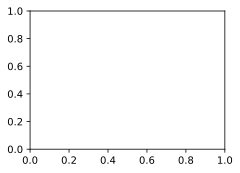

In [ ]:
lr, num_epochs = 0.9, 10

net1 = train_ch6(net, train_iter_subset, test_iter_subset, num_epochs, lr)

In [ ]:
import tensorflow as tf

In [ ]:
ctx = d2l.try_gpu()
if not ctx:  # Query the first device the first parameter is on
  ctx = list(net.collect_params().values())[0].list_ctx()[0]
metric = d2l.Accumulator(2)  # num_corrected_examples, num_examples
for X, y in test_iter:
    X, y = X.as_in_ctx(ctx), y.as_in_ctx(ctx)
    ttmp = net(X)
    i = 0
    for arr in ttmp:
      tmp = tf.constant(arr.asnumpy());
      if int(tf.argmax(tmp).numpy()) == int(y[i]):
        print('DUNG    Du doan %d thuc te %d' %(tf.argmax(tmp).numpy(),y[i]))
      else:
        print('SAI     Du doan %d thuc te %d' %(tf.argmax(tmp).numpy(),y[i]))
      i+=1

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
DUNG    Du doan 1 thuc te 1
DUNG    Du doan 2 thuc te 2
DUNG    Du doan 4 thuc te 4
DUNG    Du doan 1 thuc te 1
DUNG    Du doan 9 thuc te 9
DUNG    Du doan 2 thuc te 2
DUNG    Du doan 5 thuc te 5
DUNG    Du doan 0 thuc te 0
DUNG    Du doan 9 thuc te 9
DUNG    Du doan 3 thuc te 3
DUNG    Du doan 0 thuc te 0
DUNG    Du doan 8 thuc te 8
DUNG    Du doan 3 thuc te 3
DUNG    Du doan 0 thuc te 0
DUNG    Du doan 0 thuc te 0
DUNG    Du doan 7 thuc te 7
SAI     Du doan 4 thuc te 6
DUNG    Du doan 9 thuc te 9
DUNG    Du doan 2 thuc te 2
DUNG    Du doan 5 thuc te 5
DUNG    Du doan 7 thuc te 7
DUNG    Du doan 8 thuc te 8
DUNG    Du doan 0 thuc te 0
DUNG    Du doan 7 thuc te 7
SAI     Du doan 4 thuc te 2
DUNG    Du doan 5 thuc te 5
DUNG    Du doan 8 thuc te 8
DUNG    Du doan 2 thuc te 2
DUNG    Du doan 3 thuc te 3
DUNG    Du doan 6 thuc te 6
SAI     Du doan 3 thuc te 4
DUNG    Du doan 9 thuc te 9
DUNG    Du doan 8 thuc te 8
DUNG    Du doan 7 t